This notebook is part of the supplementary material of the work.


**Related Reference:** "GPU-optimized Matrix Method for Phase Retrieval with the Transport of Intensity Equation" Alejandro Silva and Julia Alonso.

Last modified on 10/10/2024

IT IS STRONGLY RECOMMENDED TO RUN THIS ON GOOGLE COLAB








In [206]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
# !pip install numpy scipy matplotlib tqdm


In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from tqdm import tqdm
import time
from math import comb
import cupy as cp
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import filters, measure
import os
import pandas as pd


Propagation of the Electrical Field

In [210]:
def numerical_propagation(U0z, dz, pixelsize, lambda_, method):
    if method == 'Angular Spectrum':
        k = 2 * cp.pi / lambda_
        Nx, Ny = U0z.shape
        fx = cp.fft.fftfreq(Nx, pixelsize)
        fy = cp.fft.fftfreq(Ny, pixelsize)
        FX, FY = cp.meshgrid(fx, fy)
        H = cp.exp(1j * dz * cp.sqrt(k**2 - (2 * cp.pi * FX)**2 - (2 * cp.pi * FY)**2))
        U1z = cp.fft.ifft2(cp.fft.fft2(U0z) * H)
        I1z = cp.abs(U1z)**2
        return U1z, I1z


FFT Solution Method


In [211]:
def TIE_FFT_solution(dIdz, I0, Pixelsize, k, RegPara, IntThr, True_phase=None):
    t0 = time.time()
    J = -k * dIdz
    Ny, Nx = J.shape
    Fx = (cp.arange(-Nx/2, Nx/2)) / Nx / Pixelsize
    Fy = (cp.arange(-Ny/2, Ny/2)) / Ny / Pixelsize
    U, V = cp.meshgrid(Fx, Fy)
    Lambda = 2 * cp.pi / k

    fx = cp.fft.fftshift(U)
    fy = cp.fft.fftshift(V)

    Cx = 2j * cp.pi * fx
    Cy = 2j * cp.pi * fy

    FJ = cp.fft.fft2(J)
    Fpsi = FJ * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)

    Fdpsidx = Fpsi * Cx
    Fdpsidy = Fpsi * Cy
    dpsidx = cp.real(cp.fft.ifft2(Fdpsidx))
    dpsidy = cp.real(cp.fft.ifft2(Fdpsidy))

    I0[I0 < IntThr * cp.max(I0)] = IntThr * cp.max(I0)

    dPhidx = dpsidx / I0
    dPhidy = dpsidy / I0

    FdPsidx = cp.fft.fft2(dPhidx)
    FdPsidy = cp.fft.fft2(dPhidy)

    Fd2Phidx2 = FdPsidx * Cx
    Fd2Phidy2 = FdPsidy * Cy

    d2Phidx2 = cp.real(cp.fft.ifft2(Fd2Phidx2))
    d2Phidy2 = cp.real(cp.fft.ifft2(Fd2Phidy2))
    d2Phi = d2Phidx2 + d2Phidy2

    Fd2Phi = cp.fft.fft2(d2Phi)
    Fphi = Fd2Phi * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)
    Phi = cp.real(cp.fft.ifft2(Fphi))

    t1 = time.time()
    Time = t1 - t0

    RMSE = None
    if True_phase is not None:
        err = Phi - True_phase
        err = err - cp.nanmean(err)
        RMSE = cp.sqrt(cp.nansum(err**2) / (err.size - cp.isnan(err).sum()))

    return Phi, RMSE, Time

iterDCT Method

In [213]:

def EvenFlip(A):
    temp = cp.concatenate((A, cp.fliplr(A)), axis=1)
    AA = cp.concatenate((temp, cp.flipud(temp)), axis=0)
    return AA

def TIE_DCT_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, RegPara, Method):
    dIdz_double = EvenFlip(dIdz_curr)
    Phi_curr_double = EvenFlip(Phi_curr)
    I0_double = EvenFlip(I0)
    Lambda = 2 * cp.pi / k

    J = -k * dIdz_double
    Ny, Nx = J.shape
    Fx = (cp.arange(-Nx/2, Nx/2)) / Nx / Pixelsize
    Fy = (cp.arange(-Ny/2, Ny/2)) / Ny / Pixelsize
    U, V = cp.meshgrid(Fx, Fy)

    fx = cp.fft.fftshift(U)
    fy = cp.fft.fftshift(V)

    Cx = 2j * cp.pi * fx
    Cy = 2j * cp.pi * fy

    FJ = cp.fft.fft2(J)
    Fpsi = FJ * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)

    Fdpsidx = Fpsi * Cx
    Fdpsidy = Fpsi * Cy
    dpsidx = cp.real(cp.fft.ifft2(Fdpsidx))
    dpsidy = cp.real(cp.fft.ifft2(Fdpsidy))

    I0_double[I0_double < 0.01 * cp.max(I0_double)] = cp.mean(I0_double)

    dPhidx = dpsidx / I0_double
    dPhidy = dpsidy / I0_double

    FdPsidx = cp.fft.fft2(dPhidx)
    FdPsidy = cp.fft.fft2(dPhidy)

    Fd2Phidx2 = FdPsidx * Cx
    Fd2Phidy2 = FdPsidy * Cy

    d2Phidx2 = cp.real(cp.fft.ifft2(Fd2Phidx2))
    d2Phidy2 = cp.real(cp.fft.ifft2(Fd2Phidy2))
    d2Phi = d2Phidx2 + d2Phidy2

    Fd2Phi = cp.fft.fft2(d2Phi)
    Fphi = Fd2Phi * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)
    Phi_double = cp.real(cp.fft.ifft2(Fphi))

    Phi = Phi_double[:Ny//2, :Nx//2]

    if Method == 'TIE':
        Fdphidx = Fphi * Cx
        Fdphidy = Fphi * Cy
        dphidx = cp.real(cp.fft.ifft2(Fdphidx))
        dphidy = cp.real(cp.fft.ifft2(Fdphidy))
        dPsidx = I0_double * dphidx
        dPsidy = I0_double * dphidy
        FdPsidx = cp.fft.fft2(dPsidx)
        FdPsidy = cp.fft.fft2(dPsidy)
        Fd2Psidx2 = FdPsidx * Cx
        Fd2Psidy2 = FdPsidy * Cy
        d2Psidx2 = cp.real(cp.fft.ifft2(Fd2Psidx2))
        d2Psidy2 = cp.real(cp.fft.ifft2(Fd2Psidy2))
        laplacePsi = d2Psidx2 + d2Psidy2
        dIdz_est = laplacePsi / -k
        dIdz_est = Phi_double[:Ny//2, :Nx//2]

    elif Method == 'Angular Spectrum':
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0_double) * cp.exp(1j * (Phi_double + Phi_curr_double))))
        Exp_term = cp.sqrt(1 - (Lambda * U)**2 - (Lambda * V)**2)
        H = cp.exp(1j * k * dz * Exp_term)
        H[(1 - (Lambda * U)**2 - (Lambda * V)**2) < 0] = 0
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0_double) / dz
        dIdz_est = dIdz_est[:Ny//2, :Nx//2]

    elif Method == 'Fresnel':
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0_double) * cp.exp(1j * (Phi_double + Phi_curr_double))))
        H = cp.exp(1j * k * dz * (1 - ((Lambda * U)**2 + (Lambda * V)**2) / 2))
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0_double) / dz
        dIdz_est = dIdz_est[:Ny//2, :Nx//2]

    else:
        raise ValueError("Method must be 'TIE', 'Angular Spectrum', or 'Fresnel'")

    return Phi, dIdz_est

def Iter_DCT_solution(dIdz, dz, I0, Pixelsize, k, r, Iter, JudgeFlag, Method, True_phase=None):
    if Method not in ['TIE', 'Angular Spectrum', 'Fresnel']:
        raise ValueError("Method must be 'TIE', 'Angular Spectrum', or 'Fresnel'")

    RMSE = []
    Time = []

    dIdz_curr = dIdz
    Phi_curr = cp.zeros_like(dIdz)

    if True_phase is not None:
        err = Phi_curr - True_phase
        err = err - cp.mean(err[~cp.isnan(err)])
        RMSE_Temp = cp.sqrt(cp.nansum(err**2) / (err.size - cp.isnan(err).sum()))
        RMSE.append(RMSE_Temp)

    for n in range(Iter):
        t0 = time.time()
        Phi_est, dIdz_est = TIE_DCT_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method)
        t1 = time.time()
        t2 = t1 - t0

        dIdz_temp = dIdz_curr
        if Method == 'TIE':
            dIdz_curr -= dIdz_est
        else:
            dIdz_curr = dIdz - dIdz_est

        Phi_curr += Phi_est

        if True_phase is not None:
            err = Phi_curr - True_phase
            err = err - cp.mean(err[~cp.isnan(err)])
            RMSE_Temp = cp.sqrt(cp.nansum(err**2) / (err.size - cp.isnan(err).sum()))
            RMSE.append(RMSE_Temp)
            Time.append(t2)

        if JudgeFlag:
            if cp.max(dIdz_curr) < cp.max(dIdz) * 1e-3 or cp.max(dIdz_curr) > 1.05 * cp.max(dIdz_temp):
                print(f'Iter-DCT-TIE iteration time: {n + 1}')
                break
        if n == Iter - 1:
            print(f'Iter-DCT-TIE iteration time: {Iter}')

    return Phi_curr, RMSE, Time

Universal Solution Method (US-TIE)


In [214]:


def TIE_MAX_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method):
    J = -k * dIdz_curr
    Ny, Nx = J.shape
    Lambda = 2 * cp.pi / k
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Nx, Pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Ny, Pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)

    # Calculate phi assuming uniform intensity.
    FJ = cp.fft.fft2(J / cp.max(I0))
    Fphi = FJ * (Cx * Cx + Cy * Cy) / (r / Pixelsize ** 4 + (Cx * Cx + Cy * Cy) ** 2)
    Phi = cp.real(cp.fft.ifft2(Fphi))

    if Method == 'TIE':
        # Calculate the estimate of dIdz using TIE
        Fdphidx = Fphi * Cx
        Fdphidy = Fphi * Cy
        dphidx = cp.real(cp.fft.ifft2(Fdphidx))
        dphidy = cp.real(cp.fft.ifft2(Fdphidy))
        dPsidx = I0 * dphidx
        dPsidy = I0 * dphidy
        FdPsidx = cp.fft.fft2(dPsidx)
        FdPsidy = cp.fft.fft2(dPsidy)
        Fd2Psidx2 = FdPsidx * Cx
        Fd2Psidy2 = FdPsidy * Cy
        d2Psidx2 = cp.real(cp.fft.ifft2(Fd2Psidx2))
        d2Psidy2 = cp.real(cp.fft.ifft2(Fd2Psidy2))
        laplacePsi = d2Psidx2 + d2Psidy2
        # Estimate dIdz
        dIdz_est = laplacePsi / (-k)

    elif Method == 'Angular Spectrum':
        # Calculate the estimate of dIdz using Angular Spectrum
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0) * cp.exp(1j * (Phi + Phi_curr))))
        Exp_term = cp.sqrt(1 - (Lambda * U) ** 2 - (Lambda * V) ** 2)
        H = cp.exp(1j * k * dz * Exp_term)
        H[(1 - (Lambda * U) ** 2 - (Lambda * V) ** 2) < 0] = 0  # neglect evanescent wave
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0) / dz

    elif Method == 'Fresnel':
        # Calculate the estimate of dIdz using Fresnel method
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0) * cp.exp(1j * (Phi + Phi_curr))))
        H = cp.exp(1j * k * dz * (1 - ((Lambda * U) ** 2 + (Lambda * V) ** 2) / 2))
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0) / dz

    else:
        raise ValueError("Type of transfer function must be 'Angular Spectrum' or 'Fresnel'")

    return Phi, dIdz_est



def Universal_Solution(dIdz, dz, I0, Pixelsize, k, r, Iter, JudgeFlag, Method, True_phase=None):
    if Method not in ['TIE', 'Angular Spectrum', 'Fresnel']:
        raise ValueError("Currently 'Method' only allows 'TIE', 'Angular Spectrum' or 'Fresnel'.")

    RMSE = []
    Time = []

    dIdz_curr = cp.array(dIdz)
    dIdz_temp = cp.array(dIdz)

    Phi_curr = cp.zeros_like(dIdz_curr)

    if True_phase is not None:
        err = Phi_curr - cp.array(True_phase)
        err = err - cp.mean(err[~cp.isnan(err)])
        valid_elements = ~cp.isnan(err)
        RMSE_Temp = cp.sqrt(cp.sum(err[valid_elements] ** 2) / cp.sum(valid_elements))
        RMSE.append(RMSE_Temp)

    for n in tqdm(range(1, Iter + 1)):
        # Estimate Phase with TIE_MAX_solver
        t0 = time.time()
        Phi_est, dIdz_est = TIE_MAX_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method)
        t1 = time.time()
        t2 = t1 - t0
        dIdz_temp = dIdz_curr

        # Calculate dIdz Error
        if Method == 'TIE':
            dIdz_curr = dIdz_curr - dIdz_est
        elif Method in ['Fresnel', 'Angular Spectrum']:
            dIdz_curr = cp.array(dIdz) - dIdz_est

        # Current Phase Estimate
        Phi_curr = Phi_curr + Phi_est

        # Calculate RMSE
        if True_phase is not None:
            err = Phi_curr - cp.array(True_phase)
            err = err - cp.mean(err[~cp.isnan(err)])
            valid_elements = ~cp.isnan(err)
            RMSE_Temp = cp.sqrt(cp.sum(err[valid_elements] ** 2) / cp.sum(valid_elements))
            RMSE.append(RMSE_Temp)
            Time.append(t2)

        # Check Convergence
        if JudgeFlag:
            if (cp.max(dIdz_curr) < cp.max(cp.array(dIdz)) * 1e-3 or cp.max(dIdz_curr) > 1.05 * cp.max(dIdz_temp)):
                print(f'US-TIE iteration time: {n}')
                break
        if n == Iter:
            print(f'US-TIE iteration time: {Iter}')

    Phi = Phi_curr.get()
    return Phi, RMSE, Time



Matrix Solution (MS-TIE)

In [215]:
def conv2(A, B):
    """
    A es la fft
    """
    return cp.fft.fft2(A * cp.fft.ifft2(B, axes=(0, 1)), axes=(0, 1))

def Phase_Retrieve(I0, pixelsize, dIdz, Iter, r,k, method):
    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)


    if method == "TIE":
      Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      Filter_tie[:,:,0] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)
      Filter_tie[:,:,1] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)
      Filter_tie[:,:,2] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)

      I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      I[:,:,0] = I0
      I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
      I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

      M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      M[:,:,0] = (Cx * Cx + Cy * Cy)
      M[:,:,1] = Cx
      M[:,:,2] = Cy

      FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
      FJ = Filter_tie * FJ * (-k)

      Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
      M_ones = cp.ones((3, 3), dtype = cp.complex64)
      t1 = time.time()
      for n in tqdm(range(Iter)):
          Fphi_curr += FJ
          FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))

      Fphi_curr += FJ
      time_exe = time.time() - t1
      return cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2))), time_exe

    else:

      return -1


In [9]:
import cv2
import os
import matplotlib.pyplot as plt

MAIN:

In [4]:

ancho, alto = 1000, 1000
file_path_io = './data/exp/i26.bmp'
Io =cv2.imread(file_path_io, cv2.IMREAD_GRAYSCALE).astype(np.float64)/255

file_path_iz = './data/exp/i28.bmp'
Iz =cv2.imread(file_path_iz, cv2.IMREAD_GRAYSCALE).astype(np.float64)/255


In [5]:
print(Io.shape)
print(Iz.shape)

(768, 768)
(768, 768)


In [8]:
path_base = f'./results'
os.makedirs(path_base, exist_ok = True)

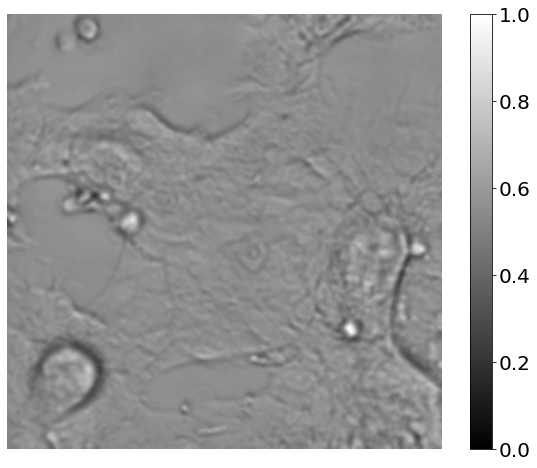

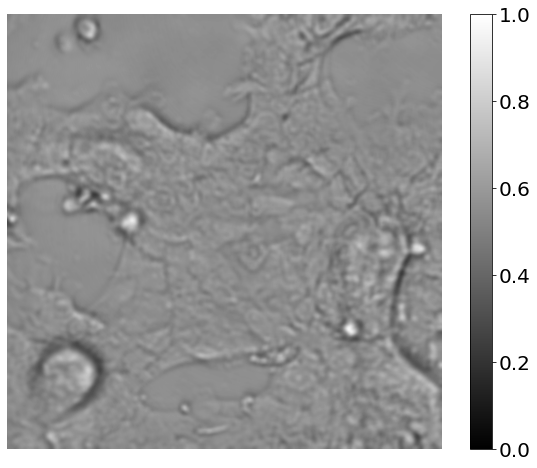

In [10]:


vmin = 0
vmax = 1


plt.figure(figsize=(10, 8))
plt.imshow(Io*1.5, cmap='gray',  vmin=vmin, vmax=vmax)
plt.axis('off')  # Eliminar los valores de los ejes
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)  # Ajusta el tamaño de las etiquetas
save_path = os.path.join( path_base, 'Io.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(Iz*1.5, cmap='gray',  vmin=vmin, vmax=vmax)
plt.axis('off')  # Eliminar los valores de los ejes
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)  # Ajusta el tamaño de las etiquetas
save_path = os.path.join( path_base, 'Iz.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()


In [ ]:
# PARAMETROS
ITER = 100

# Parámetros
dz = 10e-6
pixelsize = 2e-6
lambda_ = 550-9
k = 2 * cp.pi / lambda_
r = 1e-2
IntThr = 0.01

Nx,Ny = Io.shape

In [226]:
I0 = cp.asarray(Io)
Iz = cp.asarray(Iz)

dIdz = (Iz - I0) / dz


In [227]:
kernel_size = (9, 9)  # Tamaño del kernel del filtro
dIdz = cv2.blur(dIdz.get(), kernel_size)
dIdz = cp.asarray(dIdz)

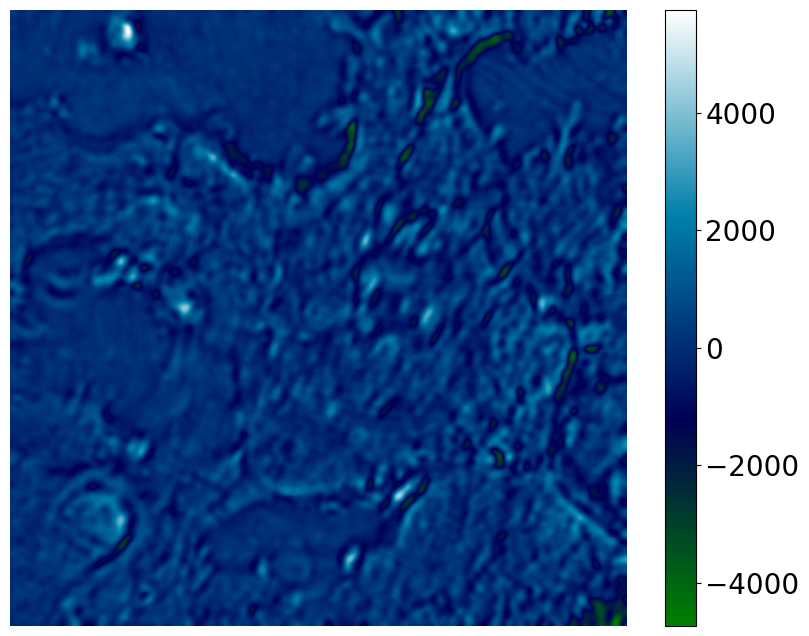

In [238]:
plt.figure(figsize=(10, 8))
plt.imshow(dIdz.get(), cmap='ocean')
plt.axis('off')  # Eliminar los valores de los ejes
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)  # Ajusta el tamaño de las etiquetas

save_path = os.path.join( path_base, 'dIdz.png')
plt.savefig(save_path, bbox_inches='tight')

plt.show()

Tiempo de ejecución: 
 0.034716129302978516 segundos


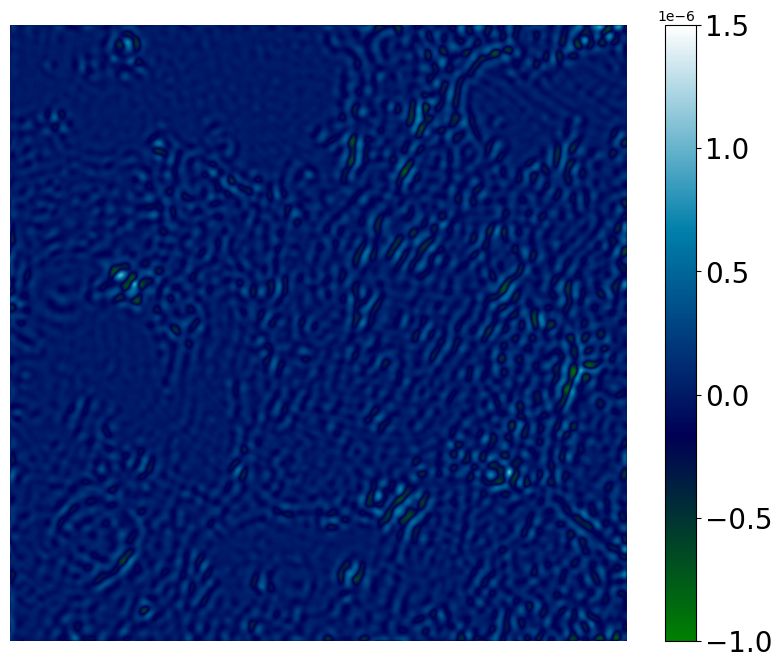

/content/drive/My Drive/Doctorado/Paper-GPU-accelerated/data-exp/results/Phi_rec_fft.png


In [235]:


start_time = time.time()

Phi_rec_fft, RMSE_fft, Time_fft = TIE_FFT_solution(1000*dIdz.copy(), I0.copy(), pixelsize, k, r, IntThr)
end_time = time.time()
execution_time_fft = end_time - start_time
print(f"Tiempo de ejecución: \n {execution_time_fft} segundos")


plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_fft.get(), cmap='ocean', vmin = -1e-6, vmax = 1.5e-6)
plt.axis('off')  # Eliminar los valores de los ejes
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)  # Ajusta el tamaño de las etiquetas
save_path = os.path.join( path_base, 'Phi_rec_fft.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(save_path)


Iter-DCT-TIE iteration time: 100
Tiempo de ejecución: 
 9.46714472770691 segundos


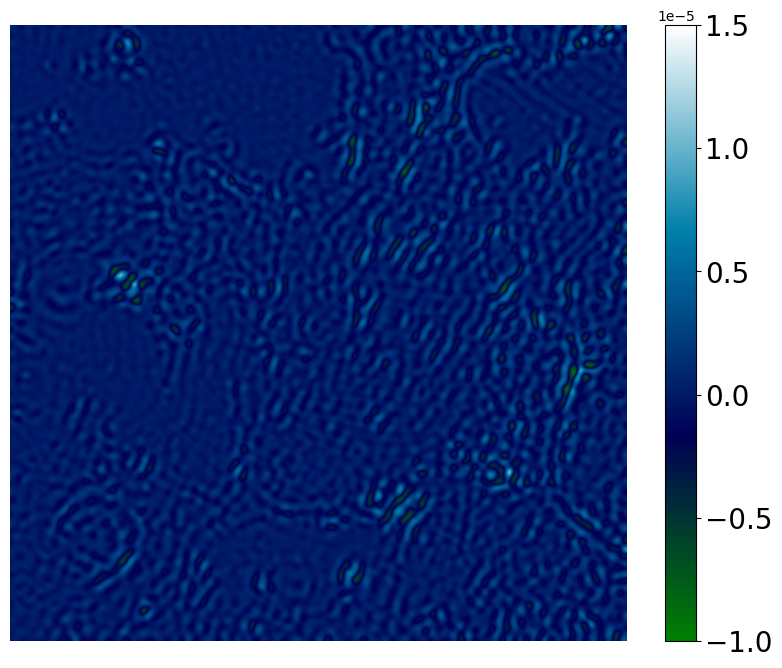

In [242]:
start_time = time.time()
Phi_rec_iterdct, RMSE_iterdct, Time_iterdct = Iter_DCT_solution(100*dIdz.copy(), dz, I0.copy(), pixelsize, k, r, ITER, 1, 'TIE')

end_time = time.time()
execution_time_iterdct = end_time - start_time
print(f"Tiempo de ejecución: \n {execution_time_iterdct} segundos")

plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_iterdct.get(), cmap='ocean', vmin = -1e-5, vmax = 1.5e-5)
plt.axis('off')  # Eliminar los valores de los ejes
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)  # Ajusta el tamaño de las etiquetas
save_path = os.path.join( path_base, 'Phi_rec_iterdct.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()



100%|██████████| 100/100 [00:00<00:00, 123.06it/s]


US-TIE iteration time: 100
Tiempo de ejecución: 
 0.9424886703491211 segundos


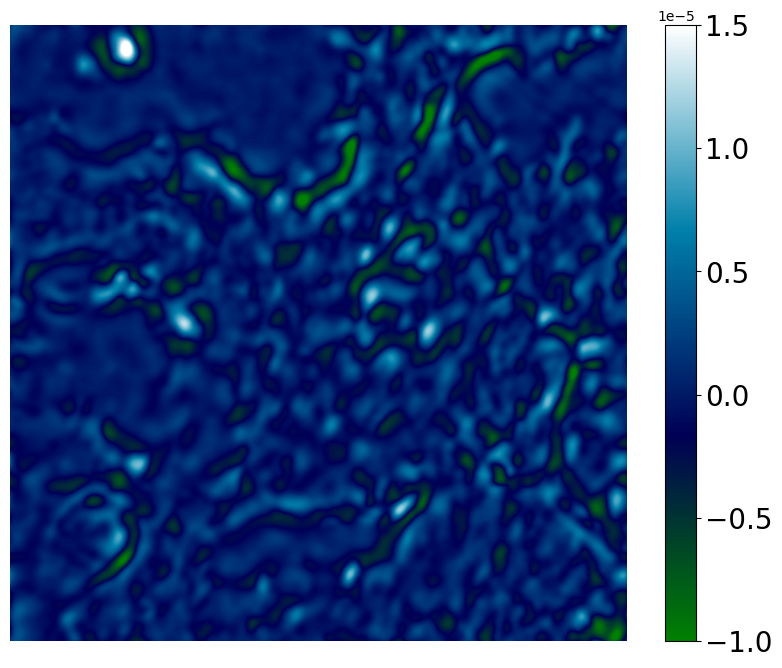

In [231]:
Method_estimate = 'TIE'

r = 1e-2
start_time = time.time()
Phi_rec_us_angspec, RMSE_us, Time_us = Universal_Solution(1000*dIdz.copy(), dz, I0.copy(), pixelsize, k, r, 100, 0, Method_estimate)
end_time = time.time()
execution_time_us_angspec = end_time - start_time
print(f"Tiempo de ejecución: \n {execution_time_us_angspec} segundos")

plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_us_angspec, cmap='ocean',vmin = -1e-5, vmax = 1.5e-5)
plt.axis('off')  # Eliminar los valores de los ejes
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)  # Ajusta el tamaño de las etiquetas
save_path = os.path.join( path_base, 'Phi_rec_us.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()


100%|██████████| 100/100 [00:00<00:00, 1119.08it/s]


Tiempo de ejecución: 
 0.09431099891662598 segundos


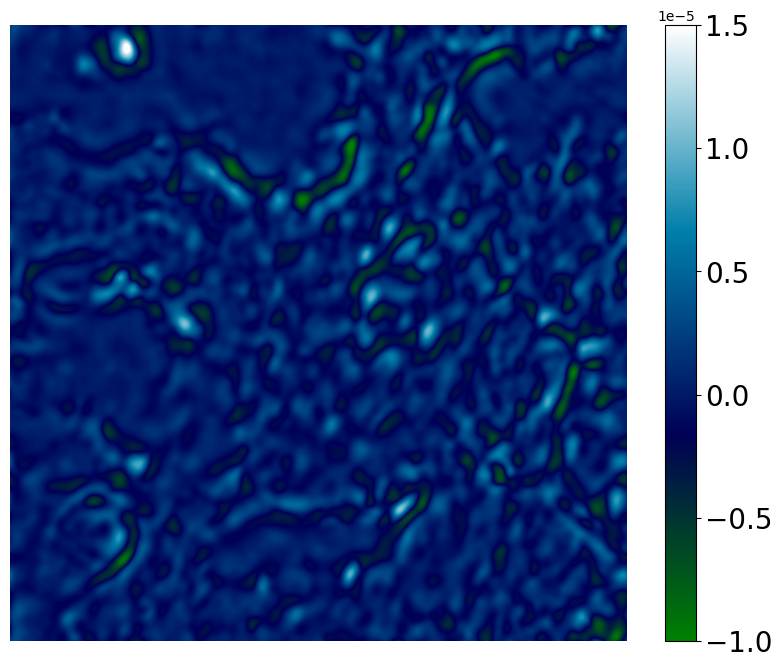

In [232]:
Method_estimate = 'TIE'

r = 1e-2
Phi_rec_mas_angspec, execution_time_mas_angspec = Phase_Retrieve(I0.copy(), pixelsize, 1000*dIdz.copy(), 100, r,k, Method_estimate)

print(f"Tiempo de ejecución: \n {execution_time_mas_angspec} segundos")


vmin = 0
vmax = 1


plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_mas_angspec.get(), cmap='ocean',vmin = -1e-5, vmax = 1.5e-5)
plt.axis('off')  # Eliminar los valores de los ejes
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)  # Ajusta el tamaño de las etiquetas
save_path = os.path.join( path_base, 'Phi_rec_ms.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()



In [243]:
dict_time = {'FFT: ':execution_time_fft,
'iterDCT: ': execution_time_iterdct,
'US-TIE: ':execution_time_us_angspec,
'mAS-TIE': execution_time_mas_angspec,
}
df_time = pd.DataFrame.from_dict(dict_time, orient='index', columns=['Time (s)'])

print(df_time)



           Time (s)
FFT:       0.034716
iterDCT:   9.467145
US-TIE:    0.942489
mAS-TIE    0.094311
